# Loading Modules

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from utils import view_dataset

In [8]:
f = torch.Tensor([[3,555,4],[3,555,4]])

translation = f[:, 1:].unsqueeze(2)
scale = f[:, 0].unsqueeze(1)
scale
scale_mat = torch.cat((scale, scale), 1)
scale_mat
torch.cat((torch.diag_embed(scale_mat), translation), 2)

tensor([[[  3.,   0., 555.],
         [  0.,   3.,   4.]],

        [[  3.,   0., 555.],
         [  0.,   3.,   4.]]])

In [9]:
class AttentionTransNet(nn.Module):
    def __init__(self):
        super(AttentionTransNet, self).__init__()

        ## The what pathway
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

        ## The spatial transformer
        self.localization = nn.Sequential(nn.Conv2d(1, 16, kernel_size=7),
                                          nn.MaxPool2d(2, stride=2),
                                          nn.ReLU(True),
                                          nn.Conv2d(16, 32, kernel_size=5),
                                          nn.MaxPool2d(2, stride=2),
                                          nn.ReLU(True),
                                          nn.Conv2d(32, 64, kernel_size=5),
                                          nn.MaxPool2d(2, stride=2),
                                          nn.ReLU(True),
                                          nn.Conv2d(64, 128, kernel_size=5),
                                          nn.MaxPool2d(2, stride=2),
                                          nn.ReLU(True))

        self.fc_loc = nn.Sequential(nn.Linear(128 * 4 * 4, 32), nn.ReLU(True),
                                    nn.Linear(32, 3))

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.zero_()
        self.fc_loc[2].bias.data.copy_(
            torch.tensor([0.2, 0, 0], dtype=torch.float)) #set scaling to 0.2

        #self.id = nn.Parameter(torch.tensor([[1, 0], [0, 1]], dtype=torch.float), requires_grad=False)

    def stn(self: object, x: torch.Tensor) -> torch.Tensor:

        xs = self.localization(x)
        xs = xs.view(-1, 128 * 4 * 4)

        theta = self.fc_loc(xs)

        translation = theta[:, 1:].unsqueeze(2)
        scale = theta[:, 0].unsqueeze(1)
        scale_mat = torch.cat((scale, scale), 1)
        theta = torch.cat((torch.diag_embed(scale_mat), translation), 2)

        #theta = theta.view(-1, 2, 3)
        #theta = torch.cat((self.id.unsqueeze(0).repeat(theta.size(0), 1, 1), theta.unsqueeze(2)), dim=2)

        grid_size = torch.Size([x.size()[0], x.size()[1], 28, 28])
        grid = F.affine_grid(theta, grid_size)
        x = F.grid_sample(x, grid)

        return x, theta

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # transform the input
        x, _ = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [10]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}


# Exploring the MNIST with where noise parameters

- 128x128 pixel with shift, noise and circular mask

In [11]:
args.offset_max = 40 #like in the paper

In [38]:
args.offset_std = 40
args.contrast = 0.7
transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args, radius = 40),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf, flexible=True),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor()
    #FullfieldRetinaWhiten(N_pic=args.N_pic),
    #FullfieldRetinaTransform(Retina(args).retina_transform_vector),
    #FullfieldToFloatTensor(),
    # Normalize(fullfield=True)
    # transforms.Normalize((args.mean,), (args.std,))
])

train_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [39]:
data_big, label_big = next(iter(train_loader))

- Let's view a couple of examples

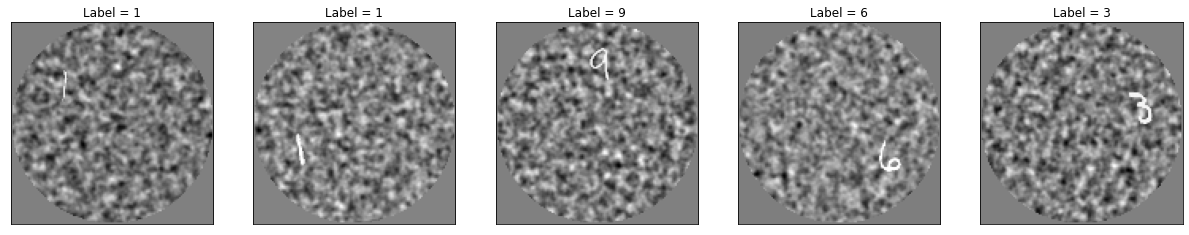

In [40]:
data = view_dataset(train_loader, n=5)

In [41]:
#data.savefig("../figures/data_128x128_noisy_no_shift_.png")

- To replace the first convolutional layer of the spatial transformer network.

# Loading the model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
#PATH = "../models/atn.pt"
#model = torch.load(PATH).to(device)
model = AttentionTransNet().to(device)

In [17]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * correct / len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

# Training parameters of the What/Where model

In [18]:
eccentricities = np.linspace(args.offset_max, 0, 9, endpoint=False)[::-1]
eccentricities

array([ 4.44444444,  8.88888889, 13.33333333, 17.77777778, 22.22222222,
       26.66666667, 31.11111111, 35.55555556, 40.        ])

In [19]:
contrasts = (0.7, 0.5, 0.3)

# Training on contrast 0.7

In [49]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [21]:
for offset in eccentricities:

    args.contrast = 0.7
    args.offset_std = offset

    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf,
                        flexible=True), 
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor()
    ])
    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform_big,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform_big,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    print("Training on eccentricity=%s" % (offset))
    args.epochs = 10

    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        test(test_loader)
        scheduler.step()

Training on eccentricity=4.444444444444443
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 2.299924
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 2.303368
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 2.295220
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 2.291330
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 2.297619
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 2.285815

Test set: Average loss: 0.0228, Accuracy: 2365/10000 (24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 2.290300
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 2.289951
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 2.281177
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 2.243586
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 2.255050
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 2.172336

Test set: Average loss: 0.0212, Accuracy: 3045/10000 (30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 2.114970
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 2.148545
Train Ep

Training on eccentricity=8.888888888888886
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.826107
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.674452
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.543388
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.627273
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.367082
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.394376

Test set: Average loss: 0.0046, Accuracy: 8580/10000 (86%)

Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.515421
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.572495
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.580069
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.348633
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.765730
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.366000

Test set: Average loss: 0.0072, Accuracy: 7736/10000 (77%)

Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.692874
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.252524
Train Epoch: 3/10 [20000/60000 (33%)]	Loss: 0.585329
Train Epoch: 3/10 [30000/60000 (50%)]	Loss: 0.731972
Tr

Training on eccentricity=13.333333333333332
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.364629
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.457097
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.321256
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.388737
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.135681
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.299017

Test set: Average loss: 0.0037, Accuracy: 8893/10000 (89%)

Adjusting learning rate of group 0 to 2.5000e-03.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.366840
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.306751
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.434311
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.265966
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.387864
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.246233

Test set: Average loss: 0.0027, Accuracy: 9185/10000 (92%)

Adjusting learning rate of group 0 to 2.5000e-03.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.217925
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.290974
Train E

Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.215321
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.198971
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.251203
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.140386
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.157303

Test set: Average loss: 0.0019, Accuracy: 9442/10000 (94%)

Adjusting learning rate of group 0 to 6.2500e-04.


Training on eccentricity=22.22222222222222
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.241061
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.122170
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.207103
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.184500
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.240631
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.113159

Test set: Average loss: 0.0017, Accuracy: 9483/10000 (95%)

Adjusting learning rate of group 0 to 6.2500e-04.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.322776
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.140167
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.294211
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.278676
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.205370
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.073939

Test set: Average loss: 0.0016, Accuracy: 9511/10000 (95%)

Adjusting learning rate of group 0 to 6.2500e-04.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.180724
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.177352
Train Ep

Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.180147
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.089654
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.222857
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.120566
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.065568

Test set: Average loss: 0.0013, Accuracy: 9588/10000 (96%)

Adjusting learning rate of group 0 to 1.5625e-04.
Training on eccentricity=31.11111111111111
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.186283
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.133038
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.107907
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.178932
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.133170
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.196335

Test set: Average loss: 0.0013, Accuracy: 9567/10000 (96%)

Adjusting learning rate of group 0 to 1.5625e-04.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.122497
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.082033
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.13774

Train Epoch: 9/10 [20000/60000 (33%)]	Loss: 0.277888
Train Epoch: 9/10 [30000/60000 (50%)]	Loss: 0.148524
Train Epoch: 9/10 [40000/60000 (67%)]	Loss: 0.169371
Train Epoch: 9/10 [50000/60000 (83%)]	Loss: 0.139739

Test set: Average loss: 0.0013, Accuracy: 9612/10000 (96%)

Adjusting learning rate of group 0 to 7.8125e-05.
Train Epoch: 10/10 [0/60000 (0%)]	Loss: 0.120544
Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.172123
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.081627
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.207364
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.182750
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.126213

Test set: Average loss: 0.0013, Accuracy: 9598/10000 (96%)

Adjusting learning rate of group 0 to 3.9063e-05.
Training on eccentricity=40.0
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.149720
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.083377
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.225607
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.104066
Train Epoc

# Training on lesser contrasts

In [50]:
optimizer = optim.SGD(model.parameters(), lr=0.001) # divide another time by 10
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [52]:
for contrast in (0.5, 0.3):
    
    print("training on contrast %s" %(contrast))

    args.offset_std = 40 #train while the maximum range is 40
    args.contrast = contrast
    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf),
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor()
    ])

    train_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=True,
                            download=True,
                            transform=transform_big,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=False,
                            download=True,
                            transform=transform_big,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)

    args.epochs = 10
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        test(test_loader)
        scheduler.step()

training on contrast 0.5
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.337771
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 2.153725
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.293269
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.213653
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.123808
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.257567

Test set: Average loss: 0.0025, Accuracy: 9264/10000 (93%)

Adjusting learning rate of group 0 to 1.0000e-03.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.413243
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.187696
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.206932
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.303220
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.232681
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.294712

Test set: Average loss: 0.0031, Accuracy: 9010/10000 (90%)

Adjusting learning rate of group 0 to 1.0000e-03.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.281238
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.202347
Train Epoch: 3/10 [20000/6

Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.421588
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.503648
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.408177
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.440473

Test set: Average loss: 0.0035, Accuracy: 8891/10000 (89%)

Adjusting learning rate of group 0 to 2.5000e-04.


# Training accuracy

In [131]:
accuracy = np.array([9627, 9264, 9010, 9252, 9392, 9349, 9375, 9407, 9425,
                     9416, 9382, 8717, 8788, 8724, 8697, 8770, 8801, 8808, 
                     8855, 8777, 8891
                    ])

Text(0.5, 0.98, 'STN Training - 128x128 dataset \nincrement Shift $\\sigma$ every 10 epochs')

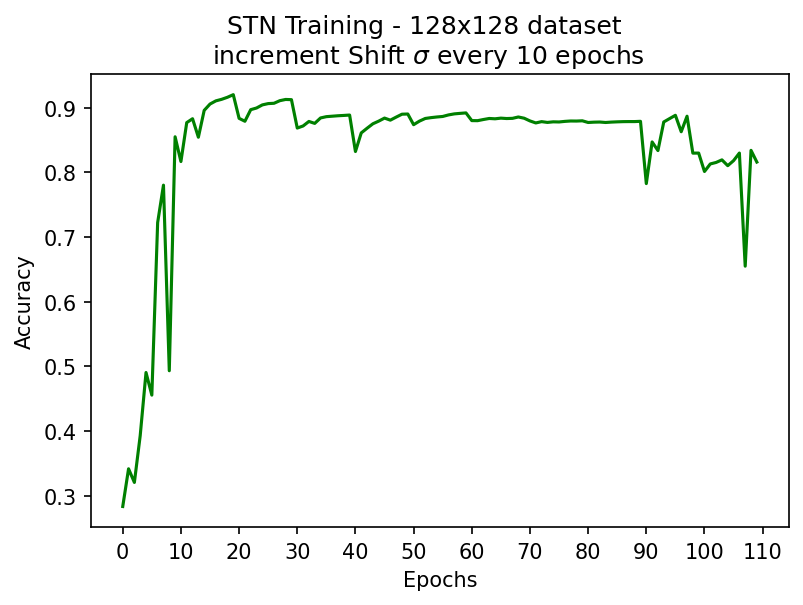

In [132]:
#plt.style.use("gadfly")
fig, ax = plt.subplots(1, 1, dpi=150)
ax.plot(accuracy, 'g')

ax.set_xticks([e for e in range(0, 120, 10)])  
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")

#ax.grid(axis='x', linestyle='--')
fig.suptitle("STN Training - 128x128 dataset \nincrement Shift $\sigma$ every 10 epochs")
#fig.savefig('../figures/acc_training_stn_128x128.png')

# Saving the model trained on all eccentricities and contrasts

In [53]:
final = "../models/atn_new_full.pt"
torch.save(model, final)

# Visualizing some results of transformation

In [64]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp
thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:16, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        data = data.type(torch.cuda.FloatTensor)
        
        output_tensor, theta = model.stn(data)
        thetas.append(theta)
        
        #output_tensor = F.pad(input=output_tensor, pad=(50, 50, 50, 50), mode='constant', value=0)

        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor, nrow=4))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor, nrow=4))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([0, 131])
        axarr[0].set_yticks([390])
        axarr[0].set_yticklabels([128])
        axarr[0].set_xticklabels([0, 128])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([0, 30])
        axarr[1].set_yticks([90])
        axarr[1].set_yticklabels([28])
        axarr[1].set_xticklabels([0, 28])

        #f.savefig('../figures/atn_attention_contrast.png')

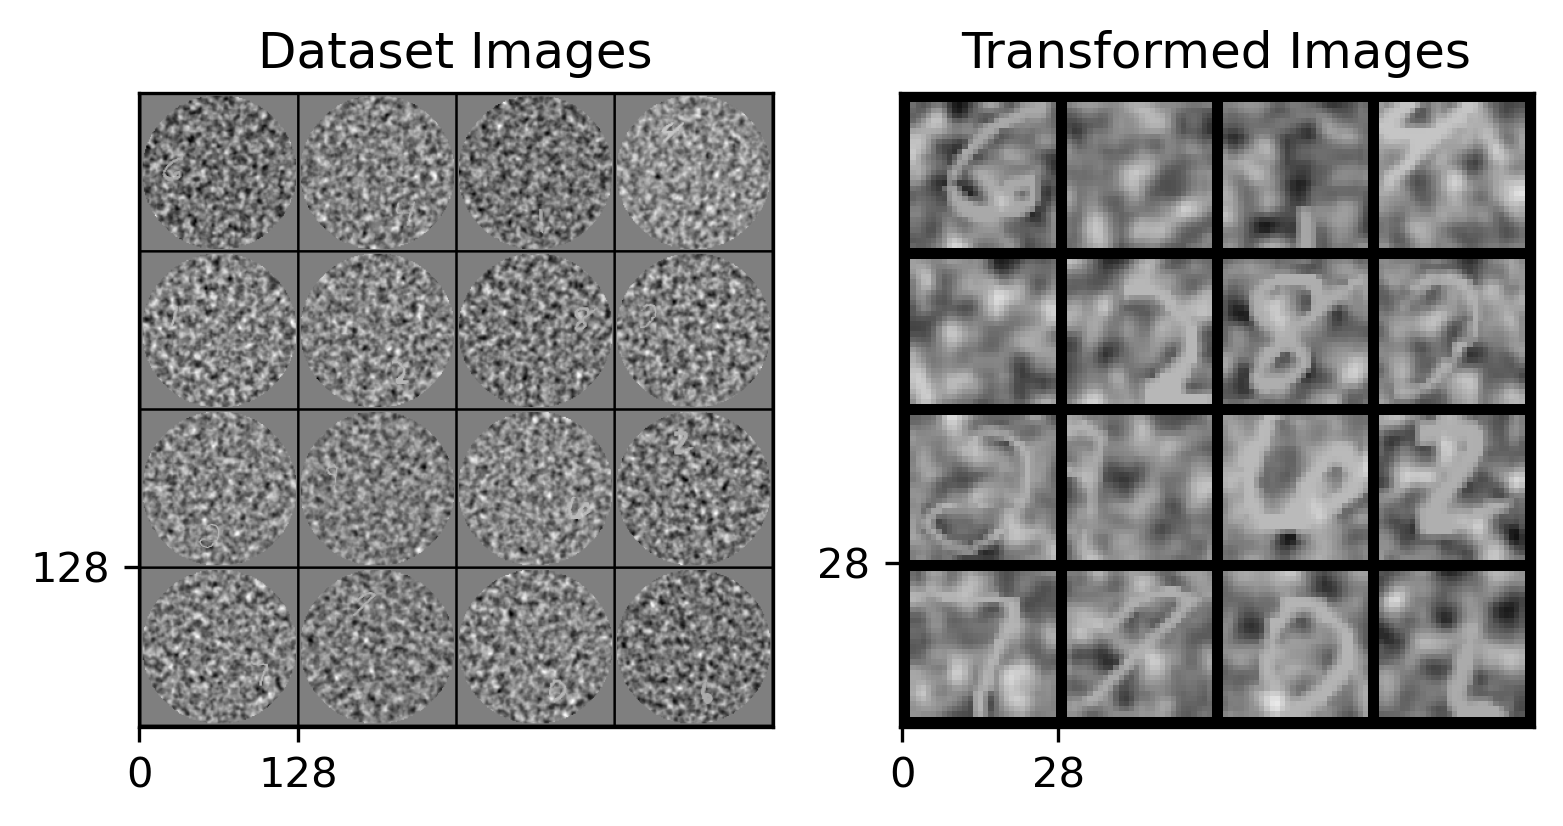

In [65]:
visualize_stn()

In [25]:
thetas

[tensor([[[ 0.2021,  0.0000, -0.0345],
          [ 0.0000,  0.2021, -0.0633]],
 
         [[ 0.2071,  0.0000,  0.0019],
          [ 0.0000,  0.2071, -0.1646]],
 
         [[ 0.2077,  0.0000, -0.0175],
          [ 0.0000,  0.2077, -0.1296]],
 
         [[ 0.2132,  0.0000,  0.0711],
          [ 0.0000,  0.2132,  0.0066]],
 
         [[ 0.2139,  0.0000, -0.0383],
          [ 0.0000,  0.2139,  0.0763]],
 
         [[ 0.2102,  0.0000, -0.0321],
          [ 0.0000,  0.2102, -0.0096]],
 
         [[ 0.2457,  0.0000,  0.3262],
          [ 0.0000,  0.2457, -0.0840]],
 
         [[ 0.2053,  0.0000, -0.1037],
          [ 0.0000,  0.2053, -0.0833]],
 
         [[ 0.2098,  0.0000, -0.0795],
          [ 0.0000,  0.2098,  0.0119]],
 
         [[ 0.2093,  0.0000, -0.0157],
          [ 0.0000,  0.2093,  0.0569]],
 
         [[ 0.2058,  0.0000, -0.0229],
          [ 0.0000,  0.2058,  0.0028]],
 
         [[ 0.2044,  0.0000, -0.0194],
          [ 0.0000,  0.2044, -0.0013]],
 
         [[ 0.2089,  0.0000,

# Performance of the ATN

- Calculating accuracy in function of eccentricity and contrast for our Spatial transformer network.

In [54]:
stn_stats = {}

for contrast in contrasts:
    print("Testing on contrast = %s"%(contrast))
    
    accuracies = []
    
    for ecc in eccentricities: 

        transform_big = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, radius = ecc), # given eccentricity
            RetinaBackground(contrast=contrast, # given contrast
                             noise=args.noise,
                             sf_0=args.sf_0,
                             B_sf=args.B_sf, flexible=False), # a fixed contrast
            RetinaMask(N_pic=args.N_pic),
            transforms.ToTensor()
        ])
        train_loader = torch.utils.data.DataLoader(MNIST('../data',
                                train=True,
                                download=True,
                                transform=transform_big,
                                ),
                                batch_size=args.minibatch_size,
                                shuffle=True)

        test_loader = torch.utils.data.DataLoader(MNIST('../data',
                                train=False,
                                download=True,
                                transform=transform_big,
                                ),
                                batch_size=args.minibatch_size,
                                shuffle=True)
        print("Testing on eccentricity = %s"%(ecc))
        acc = test(test_loader)
        accuracies.append(acc)

    stn_stats[contrast] = np.array(accuracies)

Testing on contrast = 0.7
Testing on eccentricity = 4.444444444444443

Test set: Average loss: 0.0012, Accuracy: 9606/10000 (96%)

Testing on eccentricity = 8.888888888888886

Test set: Average loss: 0.0015, Accuracy: 9509/10000 (95%)

Testing on eccentricity = 13.333333333333332

Test set: Average loss: 0.0018, Accuracy: 9417/10000 (94%)

Testing on eccentricity = 17.77777777777778

Test set: Average loss: 0.0021, Accuracy: 9324/10000 (93%)

Testing on eccentricity = 22.22222222222222

Test set: Average loss: 0.0023, Accuracy: 9224/10000 (92%)

Testing on eccentricity = 26.666666666666664

Test set: Average loss: 0.0024, Accuracy: 9218/10000 (92%)

Testing on eccentricity = 31.11111111111111

Test set: Average loss: 0.0025, Accuracy: 9147/10000 (91%)

Testing on eccentricity = 35.55555555555556

Test set: Average loss: 0.0021, Accuracy: 9335/10000 (93%)

Testing on eccentricity = 40.0

Test set: Average loss: 0.0017, Accuracy: 9456/10000 (95%)

Testing on contrast = 0.5
Testing on ecc

In [55]:
stn_stats

{0.7: array([0.9606, 0.9509, 0.9417, 0.9324, 0.9224, 0.9218, 0.9147, 0.9335,
        0.9456]),
 0.5: array([0.9314, 0.9316, 0.9248, 0.9334, 0.9258, 0.9152, 0.9177, 0.9179,
        0.9264]),
 0.3: array([0.7122, 0.6868, 0.676 , 0.6779, 0.6871, 0.6744, 0.6549, 0.6768,
        0.6111])}